In [2]:
 
 

from pathlib import Path
import sys

print("Python:", sys.version.splitlines()[0])

# TensorFlow (light check)
try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TensorFlow import failed:", str(e))

# Your dataset path (provided)
DATA_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")
print("Dataset path:", DATA_DIR)
print("Exists?:", DATA_DIR.exists())

# Example uploaded images (shown if present)
EXAMPLE1 = Path("/mnt/data/33c27e35-2bfb-45d9-9688-d036dd8c3265.png")
EXAMPLE2 = Path("/mnt/data/46b634d8-db44-4672-a1f4-7d55253641db.png")
print("Example1 exists?:", EXAMPLE1.exists())
print("Example2 exists?:", EXAMPLE2.exists())

 


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0 | GPUs: 2
Dataset path: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage
Exists?: True
Example1 exists?: False
Example2 exists?: False


In [3]:
 
# Dataset → image paths + labels → dataframe

import os
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

img_paths = []
labels = []

for class_dir in sorted(DATA_DIR.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.name
        for img in class_dir.iterdir():
            if img.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                img_paths.append(str(img))
                labels.append(class_name)

df = pd.DataFrame({"image_path": img_paths, "label": labels})

print("Total images found:", len(df))
print("\nClass distribution:")
print(df.label.value_counts())
df.head()


Total images found: 14529

Class distribution:
label
Tomato___Tomato_Yellow_Leaf_Curl_Virus           4286
Tomato___Bacterial_spot                          1702
Tomato___Late_blight                             1527
Tomato___Septoria_leaf_spot                      1417
Tomato___Spider_mites Two-spotted_spider_mite    1341
Tomato___healthy                                 1273
Tomato___Target_Spot                             1123
Tomato___Early_blight                             800
Tomato___Leaf_Mold                                761
Tomato___Tomato_mosaic_virus                      299
Name: count, dtype: int64


,image_path,label
0,/kaggle/input/plantvillage-tomato-leaf-dataset...,Tomato___Bacterial_spot
1,/kaggle/input/plantvillage-tomato-leaf-dataset...,Tomato___Bacterial_spot
2,/kaggle/input/plantvillage-tomato-leaf-dataset...,Tomato___Bacterial_spot
3,/kaggle/input/plantvillage-tomato-leaf-dataset...,Tomato___Bacterial_spot
4,/kaggle/input/plantvillage-tomato-leaf-dataset...,Tomato___Bacterial_spot


Showing sample images:


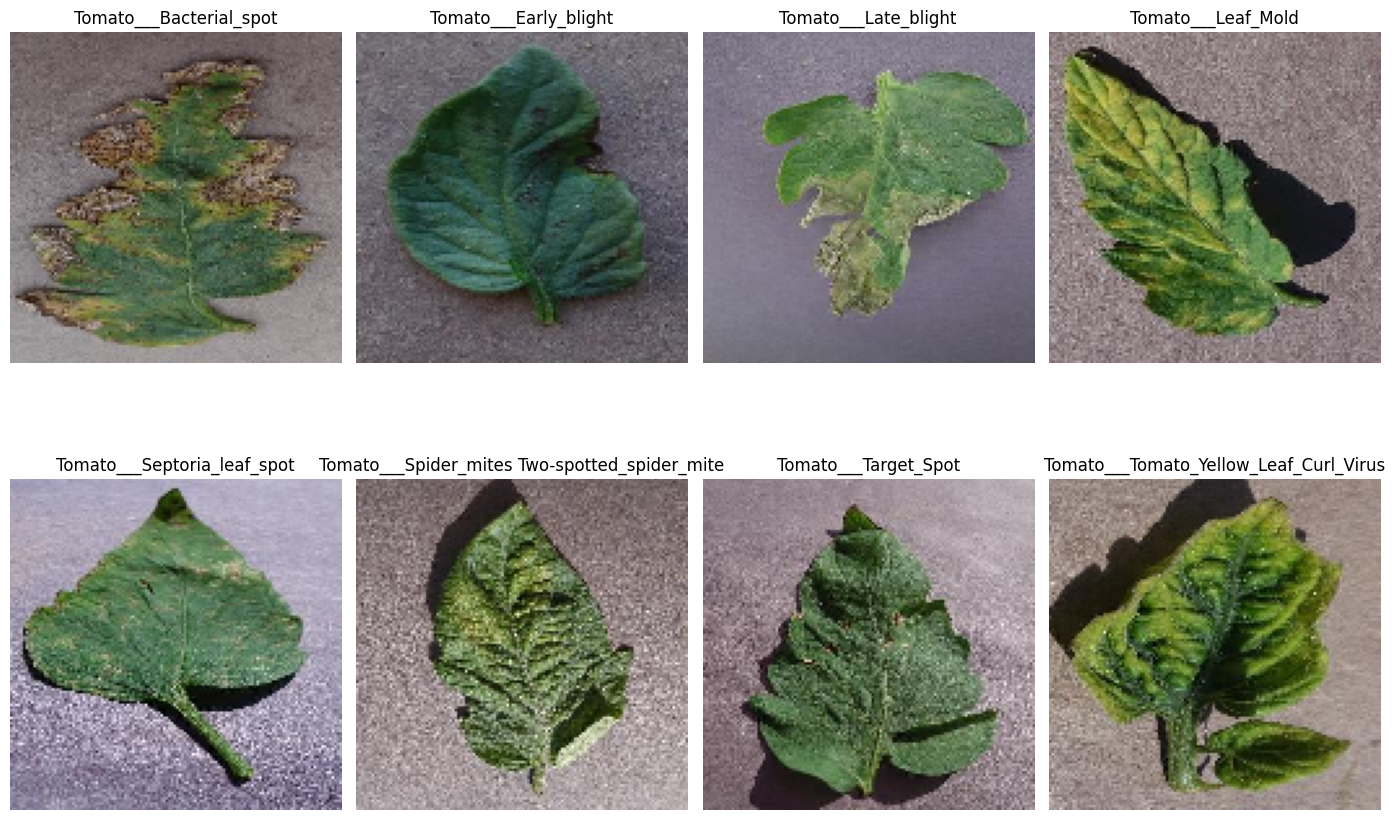

Showing class distribution:


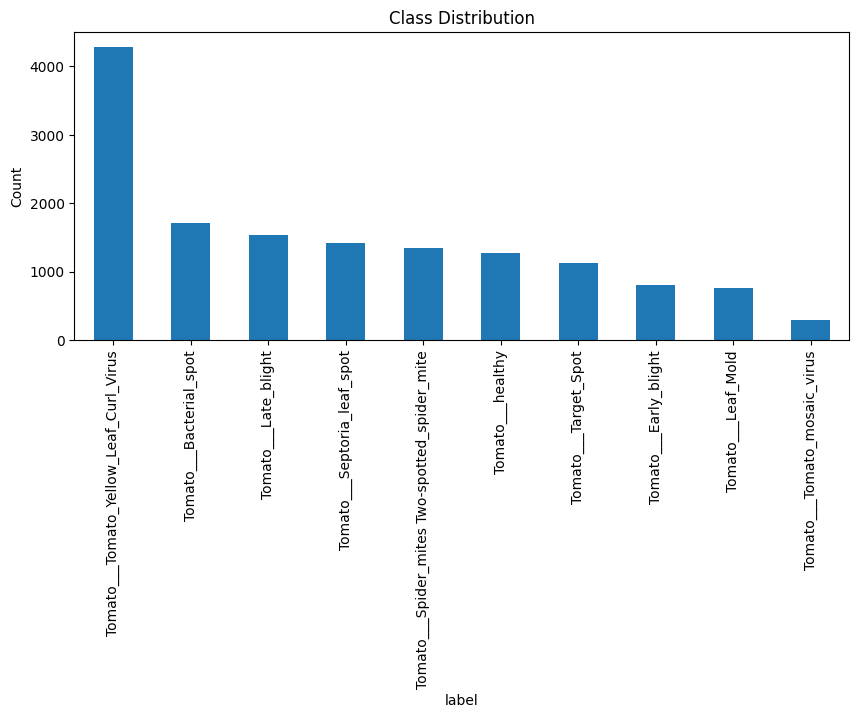

In [4]:
 
# Sample images + class distribution visualization

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# show random samples from first few classes
def show_samples(df, samples_per_class=1, image_size=(128,128)):
    classes = df.label.unique()[:8]  
    plt.figure(figsize=(14, 10))
    
    i = 1
    for c in classes:
        sample = df[df.label == c].sample(samples_per_class).iloc[0]
        img = image.load_img(sample.image_path, target_size=image_size)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(c)
        plt.axis("off")
        i += 1
    
    plt.tight_layout()
    plt.show()

print("Showing sample images:")
show_samples(df)

print("Showing class distribution:")
plt.figure(figsize=(10, 4))
df.label.value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


In [6]:
 
# Train / Test split (stratified) 
 

from sklearn.model_selection import train_test_split

# settings
TEST_SIZE = 0.20
RANDOM_STATE = 42
STRATIFY_COL = df['label']

# perform stratified split
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=STRATIFY_COL, random_state=RANDOM_STATE)

# reset indices for cleanliness
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# show basic stats
print(f"Total images: {len(df)}")
print(f"Train images: {len(train_df)} ({len(train_df)/len(df)*100:.2f}%)")
print(f"Test images : {len(test_df)} ({len(test_df)/len(df)*100:.2f}%)")
print("\nPer-class counts in Train (top 10):")
print(train_df.label.value_counts().head(10))
print("\nPer-class counts in Test (top 10):")
print(test_df.label.value_counts().head(10))

# Optional: save the splits to CSV in working directory for later use
train_csv = "/kaggle/working/train_split.csv"
test_csv  = "/kaggle/working/test_split.csv"
train_df.to_csv(train_csv, index=False)
test_df.to_csv(test_csv, index=False)
print(f"\nTrain/Test CSVs saved to:\n {train_csv}\n {test_csv}")

# Ready for next step: feature extraction / preprocessing.


Total images: 14529
Train images: 11623 (80.00%)
Test images : 2906 (20.00%)

Per-class counts in Train (top 10):
label
Tomato___Tomato_Yellow_Leaf_Curl_Virus           3429
Tomato___Bacterial_spot                          1361
Tomato___Late_blight                             1222
Tomato___Septoria_leaf_spot                      1134
Tomato___Spider_mites Two-spotted_spider_mite    1073
Tomato___healthy                                 1018
Tomato___Target_Spot                              898
Tomato___Early_blight                             640
Tomato___Leaf_Mold                                609
Tomato___Tomato_mosaic_virus                      239
Name: count, dtype: int64

Per-class counts in Test (top 10):
label
Tomato___Tomato_Yellow_Leaf_Curl_Virus           857
Tomato___Bacterial_spot                          341
Tomato___Late_blight                             305
Tomato___Septoria_leaf_spot                      283
Tomato___Spider_mites Two-spotted_spider_mite    268
Tomato_

In [8]:
# Image loader & preprocess utility (MobileNetV2-compatible)

import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from pathlib import Path

# settings
IMG_SIZE = (128, 128)

def load_and_preprocess(img_path, target_size=IMG_SIZE):
    """
    img_path: path to image file (string or Path)
    returns: numpy array shaped (H, W, 3) preprocessed for MobileNetV2 (float32)
    """
    img = image.load_img(img_path, target_size=target_size)           
    arr = image.img_to_array(img)                                      
    arr = mobilenet_preprocess(arr)   # MobileNet preprocessing (-1..1)
    return arr

# Quick tests / demos (will not error if paths missing)
example_local = Path("/mnt/data/33c27e35-2bfb-45d9-9688-d036dd8c3265.png")
fallback_path = None

if 'train_df' in globals() and len(train_df) > 0:
    fallback_path = train_df.image_path.iloc[0]
elif example_local.exists():
    fallback_path = str(example_local)

if fallback_path is not None:
    arr = load_and_preprocess(fallback_path)
    print("Loaded:", fallback_path)
    print("Preprocessed shape:", arr.shape, "| dtype:", arr.dtype,
          "| min/max:", float(arr.min()), float(arr.max()))

else:
    print("done.")


Loaded: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage/Tomato___Leaf_Mold/e40291b5-6b55-4c56-a044-3971e70eda1e___Crnl_L.Mold 7164.JPG
Preprocessed shape: (128, 128, 3) | dtype: float32 | min/max: -0.9450980424880981 0.4431372880935669


In [9]:
 
# MobileNetV2 feature extractor  
 

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

IMG_SIZE = (128,128)

print("Loading MobileNetV2...")

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model to avoid training
base_model.trainable = False

# Add GlobalAveragePooling2D for embeddings
feature_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D()
])

print("Feature extractor ready!")
print("Output embedding size:", feature_model.output_shape[-1])


Loading MobileNetV2...


I0000 00:00:1764081493.294269      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764081493.294884      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extractor ready!
Output embedding size: 1280


In [10]:
 
# Batchwise embedding extraction using the prepared `feature_model`  
 
 
# - Saves embeddings to /kaggle/working to avoid re-computation

import numpy as np
from tqdm import tqdm
from pathlib import Path

# Safety / settings
BATCH_SIZE = 64    
WORK_DIR = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

def compute_embeddings(paths, batch_size=BATCH_SIZE):
    """Compute embeddings for a list of image paths using feature_model.
       Returns a (N, D) numpy array.
    """
    n = len(paths)
    if n == 0:
        return np.zeros((0, feature_model.output_shape[-1]), dtype=np.float32)
    emb_list = []
    for i in tqdm(range(0, n, batch_size), desc="Embedding batches"):
        batch_paths = paths[i:i+batch_size]
        batch_imgs = np.stack([load_and_preprocess(p) for p in batch_paths], axis=0)  
        emb = feature_model.predict(batch_imgs, verbose=0)   
        emb_list.append(emb.astype(np.float32))
    embeddings = np.vstack(emb_list)
    return embeddings

# Run extraction (will print shapes)
print("Computing train embeddings...")
X_train_emb = compute_embeddings(train_df.image_path.tolist(), batch_size=BATCH_SIZE)
print("Train embeddings shape:", X_train_emb.shape)

print("\nComputing test embeddings...")
X_test_emb = compute_embeddings(test_df.image_path.tolist(), batch_size=BATCH_SIZE)
print("Test embeddings shape:", X_test_emb.shape)

# Save to disk for reuse
np.save(WORK_DIR / "X_train_emb.npy", X_train_emb)
np.save(WORK_DIR / "X_test_emb.npy", X_test_emb)
train_df.to_csv(WORK_DIR / "train_df.csv", index=False)
test_df.to_csv(WORK_DIR / "test_df.csv", index=False)

print(f"\nSaved embeddings and splits to {WORK_DIR}")
print("You can re-load with: np.load('/kaggle/working/X_train_emb.npy')")

 


Computing train embeddings...


Embedding batches:   0%|          | 0/182 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1764082270.832812     132 service.cc:148] XLA service 0x7c52ec00bd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764082270.834896     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764082270.834936     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764082271.322089     132 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764082274.322651     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Embedding batches: 100%|██████████| 182/182 [01:51<00:00,  1.64it/s]


Train embeddings shape: (11623, 1280)

Computing test embeddings...


Embedding batches: 100%|██████████| 46/46 [00:34<00:00,  1.34it/s]

Test embeddings shape: (2906, 1280)

Saved embeddings and splits to /kaggle/working
You can re-load with: np.load('/kaggle/working/X_train_emb.npy')


Loading embeddings and split CSVs...
Shapes -> X_train: (11623, 1280) X_test: (2906, 1280)
Unique classes: 10
After PCA -> dim: 817
Starting GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best params: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Best CV score: 0.8214748764643829

Test accuracy: 0.8341

Classification report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.83      0.96      0.89       341
                        Tomato___Early_blight       0.72      0.30      0.42       160
                         Tomato___Late_blight       0.97      0.73      0.83       305
                           Tomato___Leaf_Mold       0.80      0.77      0.78       152
                  Tomato___Septoria_leaf_spot       0.74      0.85      0.79       283
Tomato___Spider_mites Two-spotted_spider_mite       0.63      0.89      0.74     

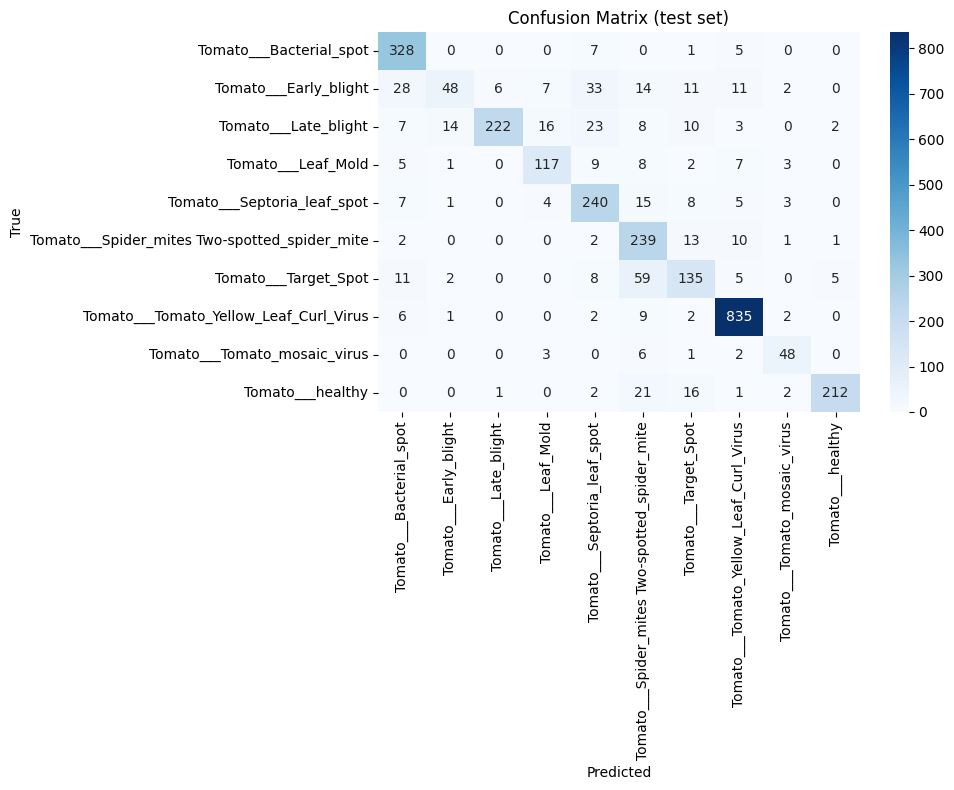

In [15]:
 
 
 
# runs a GridSearchCV on KNeighborsClassifier and prints/saves the best estimator.
 

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

WORK_DIR = Path("/kaggle/working")
X_train_path = WORK_DIR / "X_train_emb.npy"
X_test_path  = WORK_DIR / "X_test_emb.npy"
train_csv = WORK_DIR / "train_df.csv"
test_csv  = WORK_DIR / "test_df.csv"

# load
print("Loading embeddings and split CSVs...")
X_train_emb = np.load(X_train_path)
X_test_emb  = np.load(X_test_path)
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

y_train = train_df['label'].values
y_test  = test_df['label'].values

print("Shapes -> X_train:", X_train_emb.shape, "X_test:", X_test_emb.shape)
print("Unique classes:", len(np.unique(y_train)))

# 1) Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled  = scaler.transform(X_test_emb)

# 2) PCA (keep 95% variance to speed up KNN; adjust if you prefer fixed n_components)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("After PCA -> dim:", X_train_pca.shape[1])

# 3) GridSearchCV for KNN
param_grid = {
    "n_neighbors": list(range(1,26)),
    "weights": ["uniform", "distance"],
    "p": [1, 2]    
}
knn = KNeighborsClassifier()

print("Starting GridSearchCV (this may take a few minutes)...")
grid = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train_pca, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_knn = grid.best_estimator_

# 4) Evaluate on test set
y_pred = best_knn.predict(X_test_pca)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {test_acc:.4f}\n")
print("Classification report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix (plot)
labels = best_knn.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (test set)")
plt.tight_layout()
plt.show()
 





 
